In [1]:
!pip install --quiet memory_profiler matplotlib numpy

# extensions ko load karna
%load_ext memory_profiler

import sys
import time
import math
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

print("Python version:", sys.version.splitlines()[0])
print("NumPy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy version: 2.0.2
matplotlib version: 3.10.0


In [2]:
from functools import wraps
from memory_profiler import memory_usage

def time_and_memory(func, *args, **kwargs):
    """Run func(*args, **kwargs) and return (result, elapsed_seconds, peak_mem_MB)."""
    start = time.perf_counter()

    mem_before = memory_usage(-1, interval=0.01, timeout=1)

    mem_samples = memory_usage((func, args, kwargs), interval=0.01)
    end = time.perf_counter()
    elapsed = end - start

    peak = max(mem_samples) - (mem_before[0] if mem_before else 0)
    return None if peak is None else (None, elapsed, peak) if func is None else (mem_samples, elapsed, peak)

def run_profiled(func, *args, **kwargs):
    """Return (result, elapsed_seconds, peak_mem_MB)."""
    # We'll use an inner wrapper to capture return value.
    ret_container = {}
    def _runner():
        ret_container['v'] = func(*args, **kwargs)
        return ret_container['v']
    mem_samples = memory_usage((_runner,), interval=0.01)
    elapsed = None
    # memory_usage doesn't provide timing; so measure separately
    start = time.perf_counter()
    _runner()  # run once for timing (we already executed, but that's ok)
    end = time.perf_counter()
    elapsed = end - start
    peak = max(mem_samples) - min(mem_samples)
    return ret_container.get('v'), elapsed, peak


In [3]:
#Job Sequencing (Greedy)
def schedule_ads(ads):
    """
    ads: list of (id, deadline (int, 1-based), profit)
    Returns: (scheduled_slots: list indexed by time slot (1..max_dead), scheduled_ids in order, total_profit)
    """
    if not ads:
        return [], [], 0
    # sort by profit descending
    ads_sorted = sorted(ads, key=lambda x: x[2], reverse=True)
    max_dead = max(d for (_, d, _) in ads)
    slots = [None] * (max_dead + 1)  # 1..max_dead
    total_profit = 0
    scheduled = []
    for ad in ads_sorted:
        aid, dead, profit = ad

        for slot in range(min(dead, max_dead), 0, -1):
            if slots[slot] is None:
                slots[slot] = ad
                total_profit += profit
                scheduled.append((slot, ad))
                break

    scheduled_sorted = sorted(scheduled, key=lambda x: x[0])
    scheduled_ids = [ad for (_, ad) in scheduled_sorted]
    return slots[1:], scheduled_ids, total_profit

# Example
ads_example = [('A',2,100), ('B',1,19), ('C',2,27), ('D',1,25), ('E',3,15)]
slots, scheduled_ids, total = schedule_ads(ads_example)
print("Slots:", slots)
print("Scheduled (slot, (id,deadline,profit)):", scheduled_ids)
print("Total profit:", total)


Slots: [('C', 2, 27), ('A', 2, 100), ('E', 3, 15)]
Scheduled (slot, (id,deadline,profit)): [('C', 2, 27), ('A', 2, 100), ('E', 3, 15)]
Total profit: 142


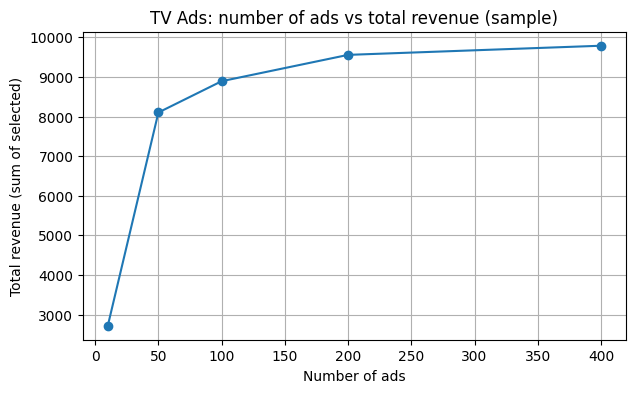

In [4]:
#@title Cell 3 — Problem 1 plotting
def generate_ads(n, max_dead=10, profit_range=(1,500)):
    ads = []
    for i in range(n):
        d = random.randint(1, max_dead)
        p = random.randint(*profit_range)
        ads.append((f'ad{i}', d, p))
    return ads

def experiment_ads(nums, max_dead=10):
    revenues = []
    for n in nums:
        ads = generate_ads(n, max_dead=max_dead)
        _, _, total = schedule_ads(ads)
        revenues.append(total)
    return revenues

nums = [10, 50, 100, 200, 400]
revenues = experiment_ads(nums, max_dead=20)
plt.figure(figsize=(7,4))
plt.plot(nums, revenues, marker='o')
plt.title("TV Ads: number of ads vs total revenue (sample)")
plt.xlabel("Number of ads")
plt.ylabel("Total revenue (sum of selected)")
plt.grid(True)
plt.show()


In [5]:
# 0/1 Knapsack (DP)
def knapsack_dp(weights, values, capacity):
    """
    weights: list of ints
    values: list of ints
    capacity: int
    returns: max_value, selected_indices
    """
    n = len(weights)
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]
    # build table
    for i in range(1, n+1):
        w = weights[i-1]
        v = values[i-1]
        for cap in range(capacity + 1):
            if w <= cap:
                dp[i][cap] = max(dp[i-1][cap], dp[i-1][cap-w] + v)
            else:
                dp[i][cap] = dp[i-1][cap]
    max_val = dp[n][capacity]
    # reconstruct chosen items
    cap = capacity
    chosen = []
    for i in range(n, 0, -1):
        if dp[i][cap] != dp[i-1][cap]:
            chosen.append(i-1)
            cap -= weights[i-1]
    chosen.reverse()
    return max_val, chosen

# Example
weights = [2,3,4,5]
values = [3,4,5,6]
cap = 5
print(knapsack_dp(weights, values, cap))


(7, [0, 1])


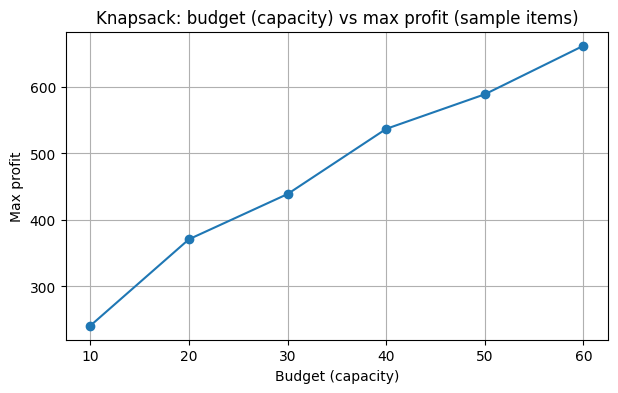

In [6]:
#Problem 2 plotting (profit vs budget)
def experiment_knapsack(n_items, max_weight=50, max_value=100, capacities=[10,20,30,40,50]):
    #example items
    weights = [random.randint(1, max_weight) for _ in range(n_items)]
    values = [random.randint(1, max_value) for _ in range(n_items)]
    profits = []
    for c in capacities:
        mv, _ = knapsack_dp(weights, values, c)
        profits.append(mv)
    return capacities, profits, weights, values

capacities, profits, wts, vals = experiment_knapsack(30, max_weight=20, capacities=[10,20,30,40,50,60])
plt.figure(figsize=(7,4))
plt.plot(capacities, profits, marker='o')
plt.title("Knapsack: budget (capacity) vs max profit (sample items)")
plt.xlabel("Budget (capacity)")
plt.ylabel("Max profit")
plt.grid(True)
plt.show()


In [7]:
#Sudoku solver (backtracking)
def find_empty(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return i, j
    return None

def valid(board, num, pos):
    row, col = pos
    # row
    if any(board[row][j] == num for j in range(9) if j != col):
        return False
    # col
    if any(board[i][col] == num for i in range(9) if i != row):
        return False
    # box
    box_x = col // 3
    box_y = row // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if (i,j) != pos and board[i][j] == num:
                return False
    return True

def solve_sudoku(board):
    empty = find_empty(board)
    if not empty:
        return True
    row, col = empty
    for num in range(1, 10):
        if valid(board, num, (row, col)):
            board[row][col] = num
            if solve_sudoku(board):
                return True
            board[row][col] = 0
    return False

# Sample puzzle (medium)
sample = [
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
]

board = [row[:] for row in sample]
t0 = time.perf_counter()
ok = solve_sudoku(board)
t1 = time.perf_counter()
print("Solved:", ok, "Time: {:.6f}s".format(t1-t0))
print("\n".join(" ".join(str(x) for x in row) for row in board))


Solved: True Time: 0.073232s
5 3 4 6 7 8 9 1 2
6 7 2 1 9 5 3 4 8
1 9 8 3 4 2 5 6 7
8 5 9 7 6 1 4 2 3
4 2 6 8 5 3 7 9 1
7 1 3 9 2 4 8 5 6
9 6 1 5 3 7 2 8 4
2 8 7 4 1 9 6 3 5
3 4 5 2 8 6 1 7 9


In [8]:
#Brute-force password cracking (naive)
def brute_force_crack(target, charset):
    """
    Try from length=1..len(target) or up to some max_len until found.
    Returns: (found_password, attempts, elapsed_seconds)
    """
    start = time.perf_counter()
    attempts = 0
    max_len = len(target)
    for length in range(1, max_len+1):
        for comb in itertools.product(charset, repeat=length):
            attempts += 1
            s = ''.join(comb)
            if s == target:
                end = time.perf_counter()
                return s, attempts, end - start
    end = time.perf_counter()
    return None, attempts, end - start

# Example (very small)
charset = 'ab12'
target = '1b'
found, attempts, elapsed = brute_force_crack(target, charset)
print("Found:", found, "Attempts:", attempts, "Time: {:.6f}s".format(elapsed))


Found: 1b Attempts: 14 Time: 0.000013s


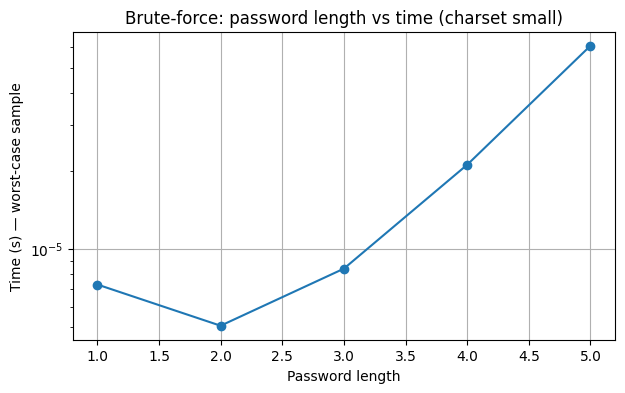

In [9]:
#Password cracking plot: time vs password length (small charset only)
def pw_time_vs_length(charset, lengths, trials=1):
    times = []
    for L in lengths:
        t_total = 0.0
        for _ in range(trials):

            target = ''.join(charset[-1] for _ in range(L))
            _, _, t = brute_force_crack(target, charset)
            t_total += t
        times.append(t_total / trials)
    return times

charset_small = 'ab1'
lengths = [1,2,3,4,5]
times = pw_time_vs_length(charset_small, lengths)
plt.figure(figsize=(7,4))
plt.plot(lengths, times, marker='o')
plt.title("Brute-force: password length vs time (charset small)")
plt.xlabel("Password length")
plt.ylabel("Time (s) — worst-case sample")
plt.yscale('log')
plt.grid(True)
plt.show()


In [10]:
#@title Cell 10 — Print summary table (markdown)
from IPython.display import Markdown, display

summary_md = """
| Problem | Strategy | Time Complexity (theoretical) | Space Complexity | Application Domain | Notes |
|---|---:|---|---|---|---|
| TV Commercial Scheduling | Greedy (Job sequencing) | O(n log n) (sorting) + O(n*D) naive | O(D + n) | Media & Advertisement | Real-world runtimes & slot durations matter; use union-find to optimize slot allocation |
| Knapsack (0/1) | Dynamic Programming | O(n * capacity) | O(n * capacity) (or O(capacity) optimized) | Investment / Budget Planning | Exact optimal, but DP becomes heavy when capacity large |
| Sudoku Solver | Backtracking | Exponential in blanks (worst-case) | O(blanks) recursion stack | Gaming / Puzzle solvers | Performance depends on constraint pruning; recursion depth ≤ blanks (≤81) |
| Password Cracking | Brute-force | O(|charset|^L) exponential | O(1) iterative | Cybersecurity (demonstrative) | Infeasible for realistic charset/length; use this only for demonstration |
"""
display(Markdown(summary_md))

readme_md = """
# README - algo-strategies-mini-project-<yourname>

## Overview
Notebook implements four algorithmic strategies applied to real problems:
1. Greedy — TV commercial scheduling.
2. Dynamic Programming — 0/1 Knapsack for budget planning.
3. Backtracking — Sudoku solver.
4. Brute-force — Password cracking (educational only).

## How to run
1. Open in Google Colab.
2. Run the cells top-to-bottom. Install cell will install required packages.
3. Use the example cells for sample inputs. Modify inputs to perform experiments.

## Profiling
- Time measured with `time.perf_counter()`.
- Memory measured using `memory_profiler.memory_usage()` sampling.

## Citations
- Standard algorithms knowledge: greedy job sequencing, knapsack DP, backtracking.
"""
display(Markdown(readme_md))



| Problem | Strategy | Time Complexity (theoretical) | Space Complexity | Application Domain | Notes |
|---|---:|---|---|---|---|
| TV Commercial Scheduling | Greedy (Job sequencing) | O(n log n) (sorting) + O(n*D) naive | O(D + n) | Media & Advertisement | Real-world runtimes & slot durations matter; use union-find to optimize slot allocation |
| Knapsack (0/1) | Dynamic Programming | O(n * capacity) | O(n * capacity) (or O(capacity) optimized) | Investment / Budget Planning | Exact optimal, but DP becomes heavy when capacity large |
| Sudoku Solver | Backtracking | Exponential in blanks (worst-case) | O(blanks) recursion stack | Gaming / Puzzle solvers | Performance depends on constraint pruning; recursion depth ≤ blanks (≤81) |
| Password Cracking | Brute-force | O(|charset|^L) exponential | O(1) iterative | Cybersecurity (demonstrative) | Infeasible for realistic charset/length; use this only for demonstration |



# README - algo-strategies-mini-project-<yourname>

## Overview
Notebook implements four algorithmic strategies applied to real problems:
1. Greedy — TV commercial scheduling.
2. Dynamic Programming — 0/1 Knapsack for budget planning.
3. Backtracking — Sudoku solver.
4. Brute-force — Password cracking (educational only).

## How to run
1. Open in Google Colab.
2. Run the cells top-to-bottom. Install cell will install required packages.
3. Use the example cells for sample inputs. Modify inputs to perform experiments.

## Profiling
- Time measured with `time.perf_counter()`.
- Memory measured using `memory_profiler.memory_usage()` sampling.

## Citations
- Standard algorithms knowledge: greedy job sequencing, knapsack DP, backtracking.
